<a href="https://colab.research.google.com/github/M0rph3e/ift6758-project-main/blob/fengineering2/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Motivation for the code and explanation [here](https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d)

In [2]:
%load_ext autoreload
%autoreload 2

In [104]:
df = px.data.medals_long()

df["kk"]=99
df["klk"]=99

In [105]:
df

,nation,medal,count,kk,klk
0,South Korea,gold,24,99,99
1,China,gold,10,99,99
2,Canada,gold,9,99,99
3,South Korea,silver,13,99,99
4,China,silver,15,99,99
5,Canada,silver,12,99,99
6,South Korea,bronze,11,99,99
7,China,bronze,8,99,99
8,Canada,bronze,12,99,99


In [106]:
import plotly.express as px

fig = px.scatter(df, y="nation", x="count", color="medal", symbol="medal",hover_data=['kk','klk'])
fig.update_traces(marker_size=10)
fig.show()

In [107]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import os
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from sklearn import feature_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import pandas as pd
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
import random
random_state = 42

In [4]:
# COMET_API_KEY = 

#create an experiment with your api key
comet_exp = Experiment(api_key=os.environ.get('COMET_API_KEY'),
                project_name='milestone_2',
                workspace="morph-e",
                auto_param_logging=False
                )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/a0c1f515f7a747038dde50dbacc6a204



In [5]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
seed = 42
seed_everything(seed)

In [6]:
### Script to get the DataFrame and Split the data into train and test set for FE1
years = [2015,2016,2017,2018]
dataset = SeasonDataSetTwo(years)
df_total = dataset.get_features_2()
df = df_total[df_total['gamePk'].astype(str).str[5]=='2']##Filtering only for regular dataframe

File already Exists, loading from ../ift6758/data/PICKLE//2015_2016_2017_2018_features2.pkl


In [7]:
print(df.shape)
df.head()

(311106, 22)


,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,...,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
0,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,True,51.0,51.0,...,0,Hit,94.0,-34.0,11.0,154.275727,False,14.025066,0.000000,0.000000
1,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,True,65.0,65.0,...,0,Giveaway,-37.0,-28.0,7.0,50.477718,False,7.211103,0.000000,0.000000
2,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,True,66.0,66.0,...,0,Shot,-79.0,0.0,1.0,4.123106,True,4.123106,4.085617,4.085617
3,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,True,113.0,113.0,...,0,Hit,-91.0,35.0,18.0,79.605276,False,4.422515,0.000000,0.000000
4,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,True,157.0,157.0,...,0,Faceoff,-69.0,-22.0,5.0,22.472205,False,4.494441,0.000000,0.000000


In [8]:
pd.set_option('display.max_columns', None)



In [9]:
df[(df[["speed"]].isin([np.nan,np.inf,-np.inf]).any(1))&(df["lastEventType"]=="Goal")&(df["gamePeriod"]==2)]

,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
36982,2015020619,San Jose Sharks,2,-83.0,3.0,Backhand,0,True,1049.0,2249.0,6.708204,26.565051,0,Goal,-85.0,8.0,0.0,5.385165,False,inf,0.0,NaN
66339,2015021104,Anaheim Ducks,2,-80.0,-5.0,Backhand,0,False,1143.0,2343.0,10.295630,-29.054604,0,Goal,-79.0,3.0,0.0,8.062258,False,inf,0.0,NaN
142832,2016021043,Toronto Maple Leafs,2,0.0,1.0,Wrist Shot,0,False,159.0,1359.0,89.005618,-0.643746,0,Goal,81.0,10.0,0.0,81.498466,False,inf,0.0,NaN
143424,2016021052,Buffalo Sabres,2,39.0,2.0,Slap Shot,0,False,935.0,2135.0,50.039984,-2.290610,0,Goal,37.0,12.0,0.0,10.198039,False,inf,0.0,NaN
183360,2017020369,Florida Panthers,2,-81.0,5.0,Wrist Shot,0,False,516.0,1716.0,9.433981,32.005383,0,Goal,-87.0,5.0,0.0,6.000000,False,inf,0.0,NaN
290046,2018020686,Pittsburgh Penguins,2,85.0,18.0,Wrist Shot,0,False,684.0,1884.0,18.439089,-77.471192,0,Goal,81.0,1.0,0.0,17.464249,False,inf,0.0,NaN


In [10]:
# df[(df["isGoal"]==1)&(df["result.strength.name"]=="Power Play")&(df["gameSeconds"]<30)]

In [11]:
features = ['gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','angleSpeed']
label = ['isGoal']

In [12]:
df_exp = df[features+label]
print(df_exp.isna().any())
df_exp.head()


gameSeconds              False
totalGameSeconds         False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
isHome                    True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
angleSpeed                True
isGoal                   False
dtype: bool


,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed,isGoal
0,51.0,51.0,11.0,1,Wrist Shot,10.007980,True,-55.0,6.0,34.525353,Hit,94.0,-34.0,154.275727,False,14.025066,0.000000,0.000000,0
1,65.0,65.0,7.0,1,Snap Shot,0.000000,True,-79.0,0.0,10.000000,Giveaway,-37.0,-28.0,50.477718,False,7.211103,0.000000,0.000000,0
2,66.0,66.0,1.0,1,Snap Shot,-4.085617,True,-75.0,-1.0,14.035669,Shot,-79.0,0.0,4.123106,True,4.123106,4.085617,4.085617,0
3,113.0,113.0,18.0,1,Wrist Shot,-46.636577,True,-55.0,-36.0,49.517674,Hit,-91.0,35.0,79.605276,False,4.422515,0.000000,0.000000,0
4,157.0,157.0,5.0,1,Tip-In,-2.045408,True,-61.0,-1.0,28.017851,Faceoff,-69.0,-22.0,22.472205,False,4.494441,0.000000,0.000000,0


In [13]:
## Removing nan and inf data of features 

remove_nan_inf_features= ["shotAngle","coordinatesX","coordinatesY","shotDistance","lastEventCoordinatesX","lastEventCoordinatesY","distanceFromLastEvent","speed","changeInShotAngle"]
# df_exp = df_exp[~df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1)]
# df_exp[df_exp[remove_nan_inf_features].isin([np.nan,np.inf,-np.inf]).any(1),re]
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)

## Filled with unknown: To be done in advanced??
# add_unknown_features = ["shotType"]
# df_exp.loc[:,add_unknown_features] = df_exp.loc[:,add_unknown_features].fillna('Unknown')

## Add One Hot to Categories
categories = ['shotType','gamePeriod','lastEventType','rebound','isHome']
# df_exp = pd.get_dummies(df_exp,columns=categories,dtype=int)
df_exp[categories]=df_exp[categories].astype("category")
## Rebound fro True/False to 1/0
# if 'rebound' in features:
#     df_exp['rebound'] = df_exp['rebound'].astype(int)
# if 'isHome' in features:
#     df_exp['isHome'] = df_exp['isHome'].astype(int)
# df


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
df_exp['isHome'].value_counts()

True     157834
False    150886
Name: isHome, dtype: int64

In [15]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311106 entries, 0 to 327280
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   gameSeconds            311106 non-null  float64 
 1   totalGameSeconds       311106 non-null  float64 
 2   timeFromLastEvent      311106 non-null  float64 
 3   gamePeriod             311106 non-null  category
 4   shotType               311068 non-null  category
 5   shotAngle              311086 non-null  float64 
 6   isHome                 308720 non-null  category
 7   coordinatesX           311088 non-null  float64 
 8   coordinatesY           311088 non-null  float64 
 9   shotDistance           311086 non-null  float64 
 10  lastEventType          311106 non-null  category
 11  lastEventCoordinatesX  306148 non-null  float64 
 12  lastEventCoordinatesY  306149 non-null  float64 
 13  distanceFromLastEvent  306133 non-null  float64 
 14  rebound             

In [16]:
df_exp.isna().any()


gameSeconds              False
totalGameSeconds         False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
isHome                    True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
angleSpeed                True
isGoal                   False
dtype: bool

In [17]:
def XY(df,label_column,features):
    X = df.drop([label_column],axis=1)[features]
    Y = df[label_column]
    # scaler = preprocessing.MinMaxScaler()
    # X=scaler.fit_transform(X)

    return X,Y

In [18]:
predscore_val_dict={}

weights_dir = "../ift6758/models/weights/"

## XGBoost with distance +angle

In [19]:
import joblib

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     70480
           1       0.43      0.00      0.01      7297

    accuracy                           0.91     77777
   macro avg       0.67      0.50      0.48     77777
weighted avg       0.86      0.91      0.86     77777



['../ift6758/models/weights//xg-dis-angle-yearvalidation.pkl']

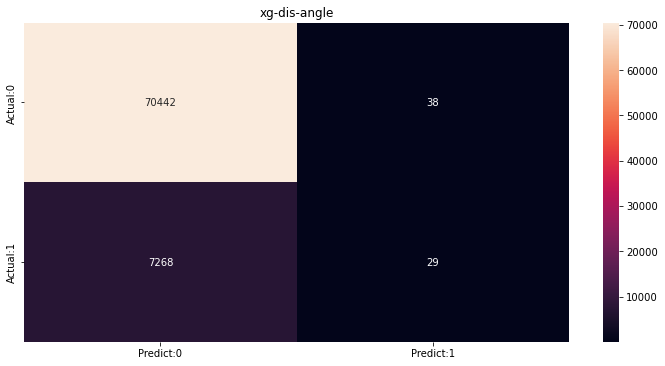

In [58]:
experiment = "xg-dis-angle"
features = ["shotDistance","shotAngle"]
label_column = "isGoal"

## Splitting X and Y
val_ratio = 0.25
X,y = XY(df_exp,label_column,features)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)

## Training
clf = xgb.XGBClassifier(booster='gbtree',use_label_encoder=False)
clf.fit(Xtrain, Ytrain)
y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
joblib.dump(clf,filename)

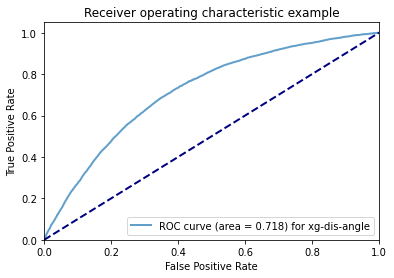

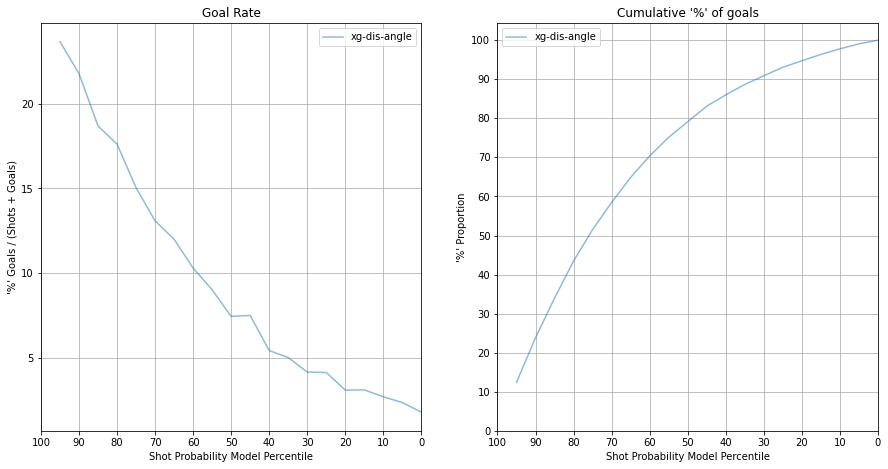

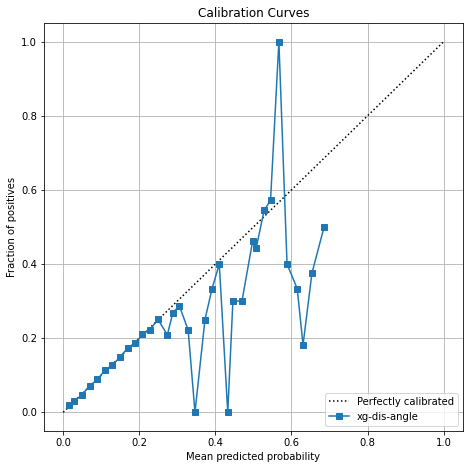

In [59]:
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)



## XG Boost with all Features


In [69]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311106 entries, 0 to 327280
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   gameSeconds            311106 non-null  float64 
 1   totalGameSeconds       311106 non-null  float64 
 2   timeFromLastEvent      311106 non-null  float64 
 3   gamePeriod             311106 non-null  category
 4   shotType               311068 non-null  category
 5   shotAngle              311086 non-null  float64 
 6   isHome                 308720 non-null  category
 7   coordinatesX           311088 non-null  float64 
 8   coordinatesY           311088 non-null  float64 
 9   shotDistance           311086 non-null  float64 
 10  lastEventType          311106 non-null  category
 11  lastEventCoordinatesX  306148 non-null  float64 
 12  lastEventCoordinatesY  306149 non-null  float64 
 13  distanceFromLastEvent  306133 non-null  float64 
 14  rebound             

In [70]:
val_ratio = 0.25
X= df_exp.drop(label,axis=1)
y= df_exp[label]


Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)


## Repeat for Best Shot


In [71]:
# To Be Done for Best Shot
### Apply XGB on features from FE2
#dictionary for collecting results
results_dict = {}
experiment = "xgbase-allfeatures"

#obtaining default parameters by calling .fit() to XGBoost model instance
xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                        )
xgb2.fit(X, y)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgb2.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgb2, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'best_params': bp}


y_pred_val  = clf0.predict(Xval)
y_pred_val_scores = clf0.predict_proba(Xval)[:,1]


Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


Fitting 3 folds for each of 1 candidates, totalling 3 fits


Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


In [72]:
## Dumping model
filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
joblib.dump(clf0,filename)

['../ift6758/models/weights//xgbase-allfeatures-yearvalidation.pkl']

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     70480
           1       0.49      0.05      0.08      7297

    accuracy                           0.91     77777
   macro avg       0.70      0.52      0.52     77777
weighted avg       0.87      0.91      0.87     77777



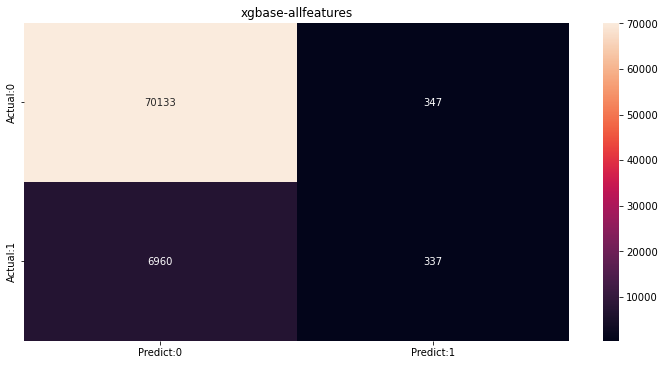

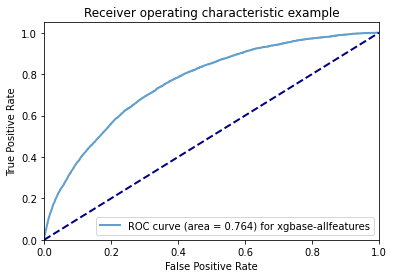

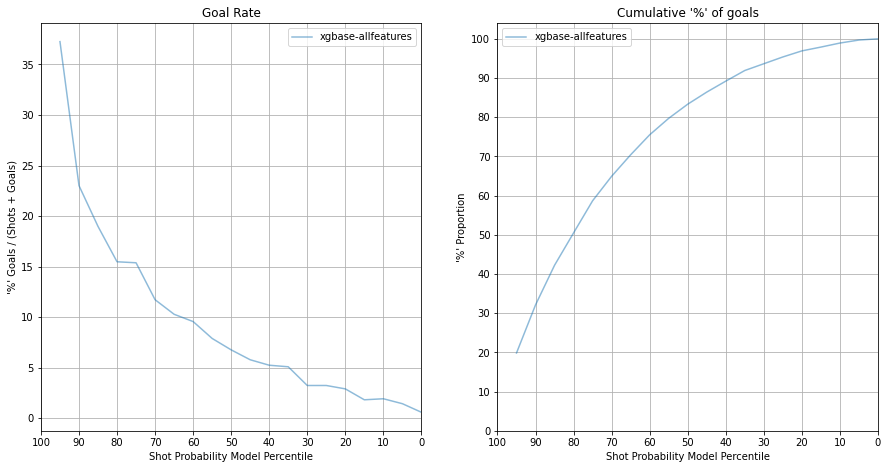

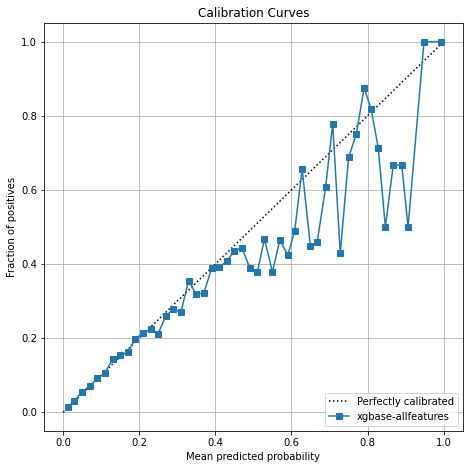

In [74]:

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)




In [75]:
###Script to perfrom generation of Graphs


In [76]:
### Script to get the DataFrame and Split the data into train and test set for FE2

## Hyperparameter Tuning


In [31]:
## cv = StratifiedKFold(
    #     n_splits=3,
    #     shuffle=True,
    #     random_state=42
    # ),
from sklearn.model_selection import StratifiedKFold


In [32]:
##Hyperparameter Tuning
#creating deepcopy of default parameters before manipulations
experiment = "xgbase-bayestuning-allfeatures"
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
              }

#No. of jobs
bcvj = int(np.cumsum([len(x) for x in param_grid.values()])[-1])

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgb3 = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgb3, search_spaces=param_grid, n_iter=bcvj, scoring='roc_auc', return_train_score=True, verbose=3,
                    cv = StratifiedKFold(
                            n_splits=3,
                            shuffle=True
                        ))
clf.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)

#best parameters
bp = clf.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                        'classifier': deepcopy(clf),
                        'cv_results': df.copy(),
                        'best_params': bp}


y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.7, max_depth=10, n_estimators=50, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.752, test=0.742) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.7, max_depth=10, n_estimators=50, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.751, test=0.748) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=25.6, learning_rate=0.7, max_depth=10, n_estimators=50, reg_alpha=51.2, reg_lambda=12.8;, score=(train=0.749, test=0.750) total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.06, max_depth=6, n_estimators=65, reg_alpha=0.4, reg_lambda=6.4;, score=(train=0.750, test=0.745) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.06, max_depth=6, n_estimators=65, reg_alpha=0.4, reg_lambda=6.4;, score=(train=0.749, test=0.748) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=51.2, learning_rate=0.06, max_depth=6, n_estimators=65, reg_alpha=0.4, reg_lambda=6.4;, score=(train=0.751, test=0.746) total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.1, max_depth=10, n_estimators=130, reg_alpha=51.2, reg_lambda=0.0;, score=(train=0.772, test=0.761) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.1, max_depth=10, n_estimators=130, reg_alpha=51.2, reg_lambda=0.0;, score=(train=0.772, test=0.760) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=1.6, learning_rate=0.1, max_depth=10, n_estimators=130, reg_alpha=51.2, reg_lambda=0.0;, score=(train=0.773, test=0.760) total time=   1.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.6, max_depth=7, n_estimators=65, reg_alpha=1.6, reg_lambda=102.4;, score=(train=0.768, test=0.763) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.6, max_depth=7, n_estimators=65, reg_alpha=1.6, reg_lambda=102.4;, score=(train=0.769, test=0.757) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=6.4, learning_rate=0.6, max_depth=7, n_estimators=65, reg_alpha=1.6, reg_lambda=102.4;, score=(train=0.770, test=0.759) total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=102.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.732, test=0.732) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=102.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.732, test=0.734) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=102.4, learning_rate=0.15, max_depth=13, n_estimators=150, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.736, test=0.729) total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.01, max_depth=6, n_estimators=50, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.757, test=0.743) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.01, max_depth=6, n_estimators=50, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.753, test=0.746) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=3.2, learning_rate=0.01, max_depth=6, n_estimators=50, reg_alpha=0.8, reg_lambda=0.8;, score=(train=0.749, test=0.746) total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.4, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2;, score=(train=1.000, test=0.712) total time=  12.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.4, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2;, score=(train=1.000, test=0.714) total time=  12.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.1, learning_rate=0.4, max_depth=13, n_estimators=100, reg_alpha=1.6, reg_lambda=3.2;, score=(train=1.000, test=0.719) total time=  12.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.15, max_depth=8, n_estimators=130, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.789, test=0.766) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.15, max_depth=8, n_estimators=130, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.790, test=0.763) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=1.6, learning_rate=0.15, max_depth=8, n_estimators=130, reg_alpha=12.8, reg_lambda=3.2;, score=(train=0.789, test=0.763) total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=65, reg_alpha=0.1, reg_lambda=25.6;, score=(train=0.806, test=0.764) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=65, reg_alpha=0.1, reg_lambda=25.6;, score=(train=0.808, test=0.765) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.2, learning_rate=0.2, max_depth=7, n_estimators=65, reg_alpha=0.1, reg_lambda=25.6;, score=(train=0.808, test=0.764) total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=0.1, reg_lambda=0.8;, score=(train=0.817, test=0.758) total time=   4.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=0.1, reg_lambda=0.8;, score=(train=0.818, test=0.757) total time=   4.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.8, learning_rate=0.03, max_depth=10, n_estimators=65, reg_alpha=0.1, reg_lambda=0.8;, score=(train=0.817, test=0.759) total time=   5.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.761, test=0.758) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.763, test=0.758) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=1.6, learning_rate=0.15, max_depth=9, n_estimators=65, reg_alpha=102.4, reg_lambda=6.4;, score=(train=0.766, test=0.750) total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


KeyboardInterrupt: 

In [ ]:
## Dumping model
filename=f"{weights_dir}/{experiment}-yearvalidation.pkl"
joblib.dump(clf,filename)

['../ift6758/models/weights//xgbase-bayestuning-allfeatures-yearvalidation.pkl']

In [ ]:

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)




NameError: name 'plot_metrics' is not defined

In [55]:
from sklearn import feature_selection as fs

* Feature Selection on only train to not overfit on validation
* Used Kaggle kernel: https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection

In [56]:
sel = fs.VarianceThreshold(threshold=0.001)  # 0.1 indicates 99% of observations approximately

sel.fit(Xtrain)  # fit finds the features with low variance

ValueError: could not convert string to float: 'Backhand'

In [33]:
Xtrain.shape

(225388, 36)

In [34]:
sum(sel.get_support())


33

In [35]:
print(
    len([
        x for x in Xtrain.columns
        if x not in Xtrain.columns[sel.get_support()]
    ]))

[x for x in Xtrain.columns if x not in Xtrain.columns[sel.get_support()]]

3


['shotType_Unknown', 'lastEventType_Goal', 'lastEventType_Penalty']

In [36]:
Xtrain['shotType_Unknown'].value_counts()
#  / np.float(len(X_train))


0    225371
1        17
Name: shotType_Unknown, dtype: int64

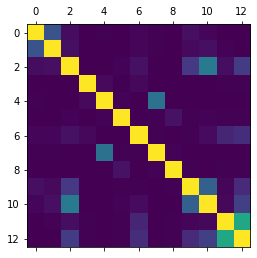

In [60]:
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
corr_matrix = Xtrain.corr().abs()
plt.matshow(corr_matrix)
plt.show()

In [61]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()


,gameSeconds,totalGameSeconds,timeFromLastEvent,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,speed,changeInShotAngle,angleSpeed
gameSeconds,NaN,0.256834,0.034447,0.000558,0.004326,0.002471,0.017294,0.004668,0.002945,0.042476,0.017347,0.003772,0.000528
totalGameSeconds,NaN,NaN,0.040451,0.003763,0.001305,0.001047,0.015716,0.004757,0.000067,0.023742,0.039418,0.008413,0.003530
timeFromLastEvent,NaN,NaN,NaN,0.000593,0.000870,0.009549,0.043945,0.000405,0.003614,0.166149,0.417809,0.037540,0.175513
shotAngle,NaN,NaN,NaN,NaN,0.024254,0.001732,0.022459,0.003493,0.000398,0.002245,0.000063,0.007443,0.005966
coordinatesX,NaN,NaN,NaN,NaN,NaN,0.009450,0.003693,0.373236,0.003064,0.001416,0.001094,0.002665,0.001718


In [71]:
upper[upper['angleSpeed']>0.5]

,gameSeconds,totalGameSeconds,timeFromLastEvent,shotAngle,coordinatesX,coordinatesY,shotDistance,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,speed,changeInShotAngle,angleSpeed
changeInShotAngle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598445


In [69]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
print(to_drop)

['angleSpeed']


In [63]:
clf.best_estimator_.feature_importances_


array([0.02671321, 0.05891316, 0.1037575 , 0.04404623, 0.0421422 ,
       0.04155611, 0.02243151, 0.01936454, 0.09643009, 0.2761009 ,
       0.03374998, 0.02278364, 0.02864612, 0.02796253, 0.04837033,
       0.0311576 , 0.04347844, 0.03239591], dtype=float32)

In [64]:

feature_scores = pd.Series(clf.best_estimator_.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)

feature_scores

shotDistance             0.276101
timeFromLastEvent        0.103758
coordinatesY             0.096430
totalGameSeconds         0.058913
rebound                  0.048370
gamePeriod               0.044046
changeInShotAngle        0.043478
shotType                 0.042142
shotAngle                0.041556
lastEventType            0.033750
angleSpeed               0.032396
speed                    0.031158
lastEventCoordinatesY    0.028646
distanceFromLastEvent    0.027963
gameSeconds              0.026713
lastEventCoordinatesX    0.022784
isHome                   0.022432
coordinatesX             0.019365
dtype: float32

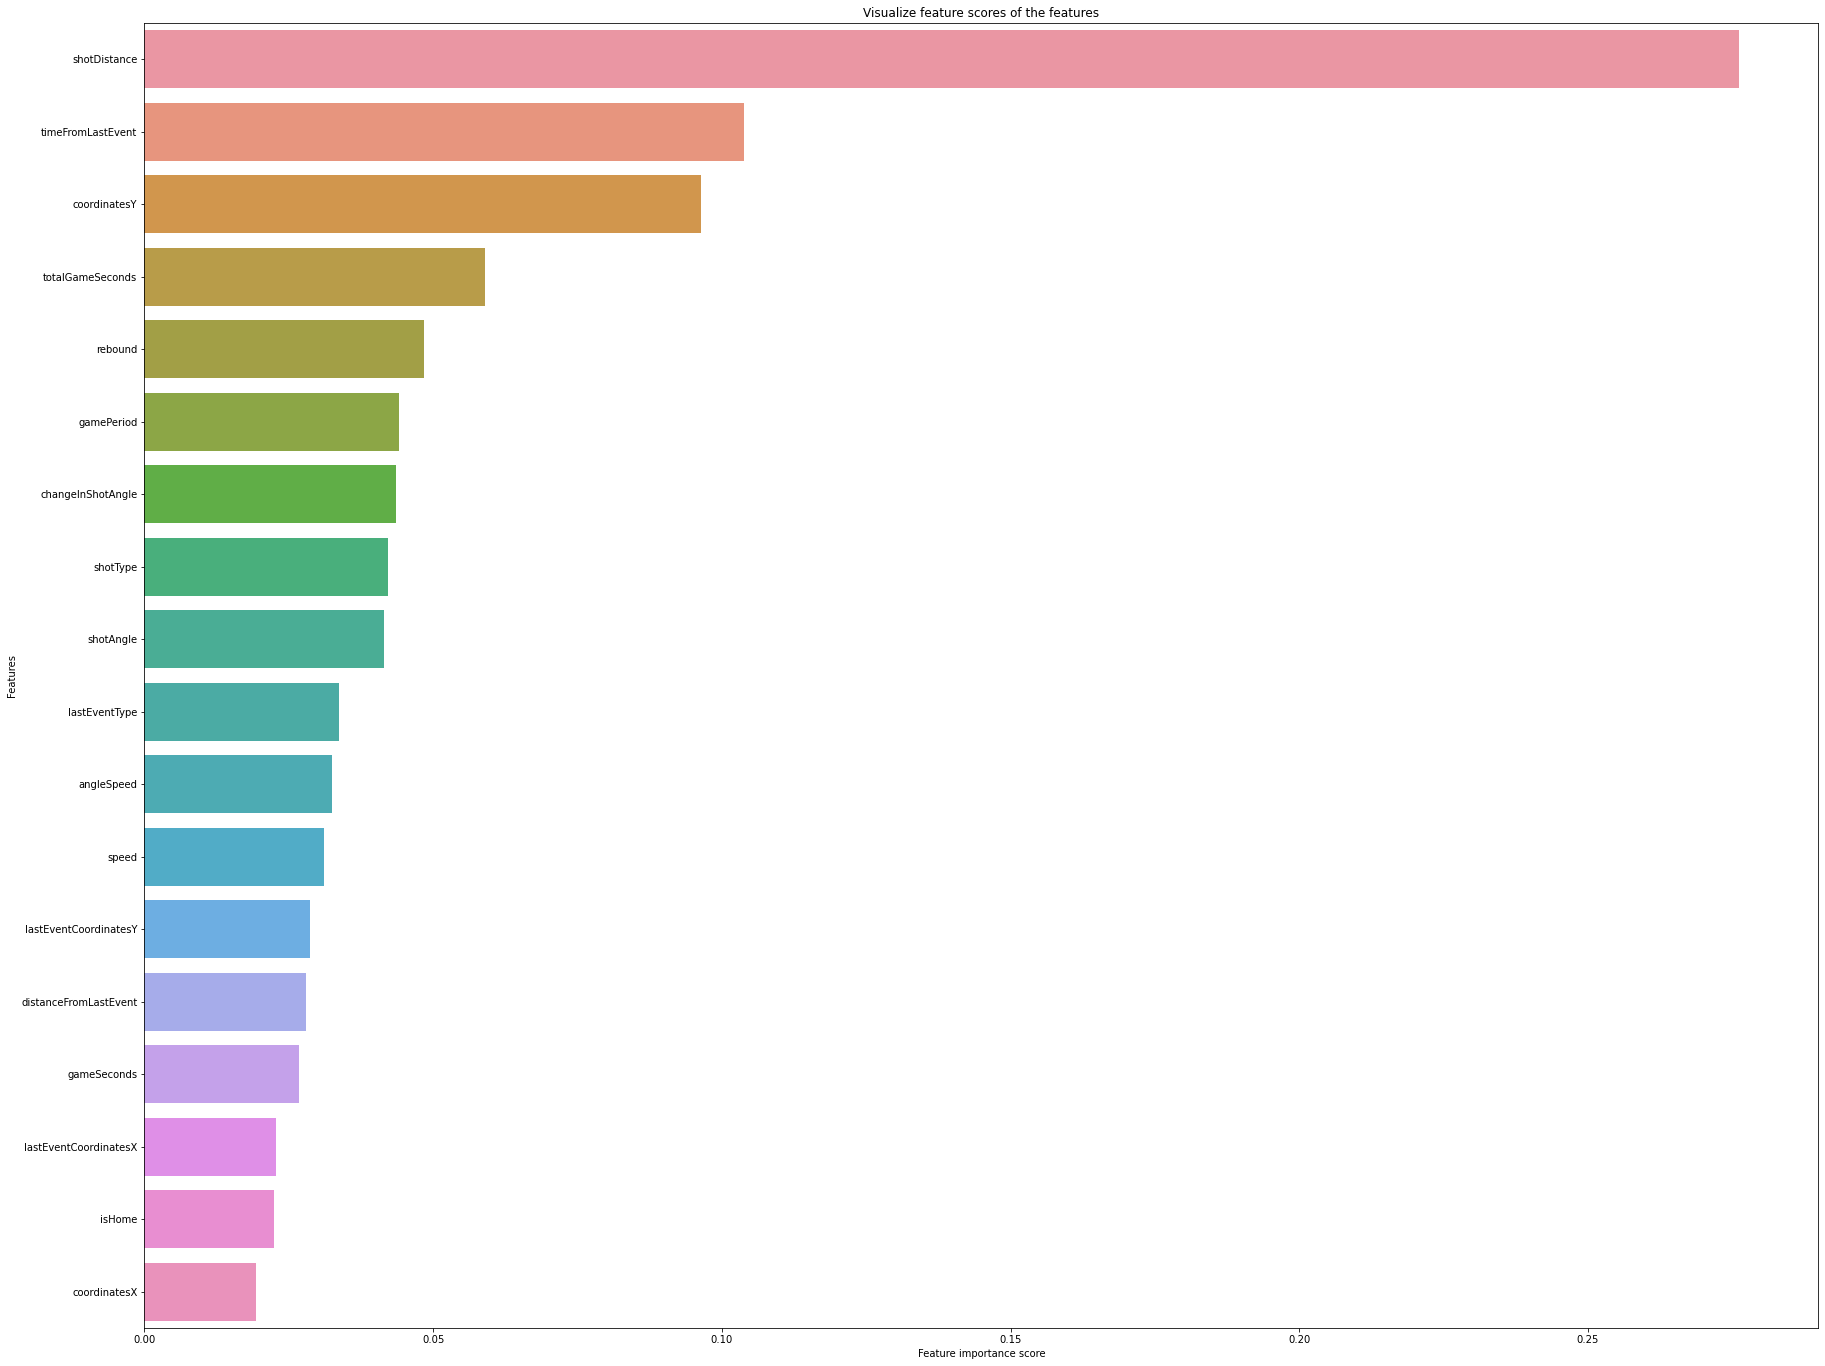

In [65]:
# Creating a seaborn bar plot
import seaborn as sns
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [33]:
import shap
import numpy as np

In [37]:
gparams["categorical_feature"]=categories


In [38]:
gparams

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': 1,
 'gamma': 0,
 'gpu_id': 0,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'auc',
 'grow_policy': 'lossguide',
 'categorical_feature': ['shotType',
  'gamePeriod',
  'lastEventType',
  'rebound',
  'isHome']}

In [66]:
# Xtrain_shap = Xtrain.copy()
# for category in categories:
#     Xtrain_shap[category] = Xtrain[category].cat.codes

In [48]:
Xtrain.shape

(233329, 18)

In [47]:
Xtrain_shap.shape

(233329, 18)

In [51]:
Xtrain

,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
161542,1069.0,1069.0,25.0,0,6,-25.016893,1,-74.0,-7.0,16.552945,14,-79.0,-1.0,7.810250,1,0.312410,19.306300,0.772252
182381,481.0,481.0,28.0,0,2,26.113913,0,-38.0,25.0,56.797887,0,76.0,-3.0,117.388245,0,4.192437,0.000000,0.000000
173944,240.0,1440.0,10.0,1,2,-28.810794,1,49.0,22.0,45.650849,1,69.0,-22.0,48.332184,0,4.833218,0.000000,0.000000
101259,173.0,3773.0,32.0,3,3,12.339087,1,-57.0,7.0,32.756679,1,-69.0,-22.0,31.384710,0,0.980772,0.000000,0.000000
167548,336.0,336.0,18.0,0,0,82.303948,0,84.0,-37.0,37.336309,1,69.0,-22.0,21.213203,0,1.178511,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79634,53.0,53.0,1.0,0,6,5.710593,1,79.0,-1.0,10.049876,14,78.0,-1.0,1.000000,1,1.000000,0.516164,0.516164
179146,231.0,1431.0,10.0,1,2,53.530766,1,-72.0,23.0,28.600699,14,54.0,1.0,127.906216,1,12.790622,55.167343,5.516734
109695,1121.0,2321.0,6.0,1,5,-81.869898,0,-88.0,-7.0,7.071068,3,-76.0,38.0,46.572524,0,7.762087,0.000000,0.000000
278530,622.0,3022.0,17.0,2,4,-6.009006,1,70.0,2.0,19.104973,1,69.0,-22.0,24.020824,0,1.412990,0.000000,0.000000


## Shap fails for Categorical Variables with XGBoost ( Tried this fix (https://stackoverflow.com/questions/57285499/how-to-tell-the-shap-tree-explainer-and-shap-values-calculator-which-variables-a) for LGBM but didn't work for XGBM)

In [65]:
# # model = clf.best_estimator_
# model = xgb2


# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# explainer = shap.TreeExplainer(model)
# explainer.model.original_model.params = gparams
# shap_values = explainer.shap_values(Xtrain,y=Ytrain)
# # shap_values = explainer(Xtrain)

# # visualize the first prediction's explanation
# # shap.plots.waterfall(shap_values[0])

In [64]:
# shap_values.shape

In [63]:
# shap.summary_plot(shap_values, Xtrain.values, plot_type="bar", class_names= ['Shot','Goal'], feature_names = Xtrain.columns)


In [62]:
# shap.summary_plot(shap_values, Xtrain.values, feature_names = Xtrain.columns)


In [61]:
# summarize the effects of all the features
# shap.plots.beeswarm(shap_values)

In [60]:
# shap.plots.bar(shap_values)


In [67]:
from sklearn.feature_selection import RFECV


In [78]:
param_grid.keys() = ["estima"]

dict_keys(['gamma', 'learning_rate', 'max_depth', 'n_estimators', 'reg_alpha', 'reg_lambda'])

In [80]:
default_params_xgb

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': 1,
 'gamma': 0,
 'gpu_id': 0,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'auc',
 'grow_policy': 'lossguide'}

In [79]:
##Hyperparameter Tuning
#creating deepcopy of default parameters before manipulations
experiment = "xgbase-bayestuning-featureselection"
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'estimator__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'estimator__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'estimator__max_depth': [5,6,7,8,9,10,11,12,13,14],
              'estimator__n_estimators': [50,65,80,100,115,130,150],
              'estimator__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'estimator__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
              }

#No. of jobs
bcvj = int(np.cumsum([len(x) for x in param_grid.values()])[-1])

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgb3 = xgb.XGBClassifier(**default_params_xgb)

rfecv = RFECV(estimator=xgb3, 
              step=1, 
              cv=StratifiedKFold(3), 
              scoring = 'roc_auc')

clf = BayesSearchCV(estimator=rfecv, search_spaces=param_grid, n_iter=bcvj, scoring='roc_auc', return_train_score=True, verbose=3,
                    cv = StratifiedKFold(
                            n_splits=3,
                            shuffle=True
                        ))
clf.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)

#best parameters
bp = clf.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                        'classifier': deepcopy(clf),
                        'cv_results': df.copy(),
                        'best_params': bp}


y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but RFECV was fitted with feature names

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



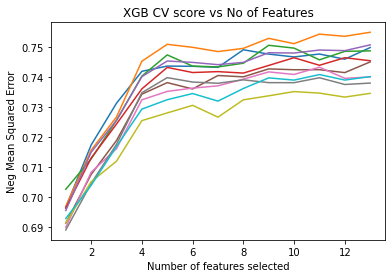

In [93]:
# Reference: https://www.kaggle.com/attackgnome/basic-feature-benchmark-rfecv-xgboost
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(**default_params_xgb)
selector = RFECV(estimator, step=1, min_features_to_select=1, cv=10, scoring='roc_auc',verbose=1,n_jobs=4)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(Xtrain.drop(categories,axis=1), Ytrain.values.flatten())


#PLot # of features selected vs. Model Score
import matplotlib.pyplot as plt
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Neg Mean Squared Error")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

#get rank of X model features
rank = selector.ranking_
#Subset features to those selected by recursive feature elimination
#X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(Xval)



In [95]:
Xtrain.drop(categories,axis=1).columns[selector.support_]

Index(['gameSeconds', 'totalGameSeconds', 'timeFromLastEvent', 'shotAngle',
       'coordinatesX', 'coordinatesY', 'shotDistance', 'lastEventCoordinatesX',
       'lastEventCoordinatesY', 'distanceFromLastEvent', 'speed',
       'changeInShotAngle', 'angleSpeed'],
      dtype='object')

In [96]:
Xtrain.drop(categories,axis=1).columns[np.logical_not(selector.support_)]

Index([], dtype='object')

In [82]:
#X_train_scaled = X_train_scaled[:,selector.support_ ] 


gameSeconds               float64
totalGameSeconds          float64
timeFromLastEvent         float64
gamePeriod               category
shotType                 category
shotAngle                 float64
isHome                   category
coordinatesX              float64
coordinatesY              float64
shotDistance              float64
lastEventType            category
lastEventCoordinatesX     float64
lastEventCoordinatesY     float64
distanceFromLastEvent     float64
rebound                  category
speed                     float64
changeInShotAngle         float64
angleSpeed                float64
dtype: object

In [90]:
## Not dropping any features and using L1 reguraliser